In [1]:
""" Read the soil solution concentrations (umol/L) from 
Hubbard Brook watershed 1 """
import xarray as xr
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from shared_read_HBR import *
from matplotlib import cm
from utils import vert_interp
from scipy import stats

## Soil CEC content - initial state

The soil pedon file does not have Oi/Oe horizons. The CEC file only has Oi/Oe, Oa, and top 10cm mineral soils. 

Use the Oie & Oa values from the latter. The rest from the former. 

Average the soil profiles according to Oie, Oa, A, E, Bhs; deeper layers are not needed since only
keep track of top 30cm

In [2]:
# (1) Surface data
data = pd.read_excel(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                  'Hubbard_Brook', 'knb-lter-hbr.158.1',
                                  'w1ffexchem.xlsx'),
                     index_col = [3, 2])
data = data.loc[data['Year'] < 1999, :]

# 'Min', 'cor', 'min' probably all means mineral soil of top 10cm
new_index_level_0 = [t if t in ['Oa', 'Oie'] else 'Min' for t in data.index.get_level_values(0)]
data.index = pd.MultiIndex.from_arrays([new_index_level_0, data.index.get_level_values(1)], 
                                        names = ['Horizon','Plot'])
data = data[['pHs', 'ExAcidcmolc_kg','ExCacmolc_kg', 'ExMgcmolc_kg', 
             'ExNacmolc_kg', 'ExKcmolc_kg', 'ExAlcmolc_kg']].sort_index()
data[data < 0] = np.nan

# subtract the Al3+ from Acid exchange to get the H+
data['ExAcidcmolc_kg'] = data['ExAcidcmolc_kg'] - data['ExAlcmolc_kg'].values

# data = data.loc[['Oa','Oie'], :]
cec_top = data.groupby('Horizon').mean()
cec_top_05 = data.groupby('Horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 5, axis = 0), index = df.columns))
cec_top_95 = data.groupby('Horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 95, axis = 0), index = df.columns))

In [3]:
# (2) Deeper data, watershed 1; Can also use watershed 3 because it is a
#     hydrological reference watershed - but we already have all the horizons
#     in watershed 1, there is no need.
path_pedon = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'Hubbard_Brook',
                            'knb-lter-hbr.210.2')
pedon = pd.read_csv(os.path.join(path_pedon, 'pedon.csv'))
pedon = pedon.loc[((pd.DatetimeIndex(pedon['date']).year <= 1998) & \
                   (pedon['project'] == 'WS1lys')) | # pedon['pedon'].str.startswith('WS3') |
                  pedon['pedon'].isin(['HB013', 'HB026', 'HB175']), 'pedon']

horizon = pd.read_csv(os.path.join(path_pedon, 'horizon.csv'))
horizon = horizon.loc[horizon['pedon'].isin(pedon), 
                      ['pedon', 'horizon', 'top_cm', 'base_cm', 'acid_KCl', 'pH_CaCl2', 
                       'Ca_NH4Cl', 'Mg_NH4Cl', 'K_NH4Cl', 'Na_NH4Cl', 'Al_NH4Cl']]
horizon.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_pedons.csv'))
#horizon['horizon'] = [
#    r[:-1] if r.endswith('1') or r.endswith('2') or r.endswith('3') else r \
#    for r in horizon['horizon']]
horizon['horizon'] = [r[:1] for r in horizon['horizon']] # let Bxxx -> B
bedrock_depth = horizon.loc[horizon['horizon'] == 'R', 'top_cm']

horizon_top = horizon.loc[horizon['horizon'].isin(['A', 'E', 'B', 'C']),
                            ['pedon', 'horizon', 'top_cm']].set_index(['horizon', 'pedon']).sort_index()
horizon_depth = horizon.loc[horizon['horizon'].isin(['A', 'E', 'B', 'C']),
                            ['pedon', 'horizon', 'base_cm']].set_index(['horizon', 'pedon']).sort_index()

horizon = horizon.loc[horizon['horizon'].isin(['A', 'E', 'B', 'C']), 
                      :].drop(['top_cm', 'base_cm'], axis = 1).set_index(['pedon', 'horizon'])
cec_min = horizon.groupby(['horizon']).mean()
cec_min_05 = horizon.groupby('horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 5, axis = 0), index = df.columns))
cec_min_95 = horizon.groupby('horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 95, axis = 0), index = df.columns))

Text(0.5, 1.0, 'Bedrock depth (Watershed 1 + Watershed 3)')

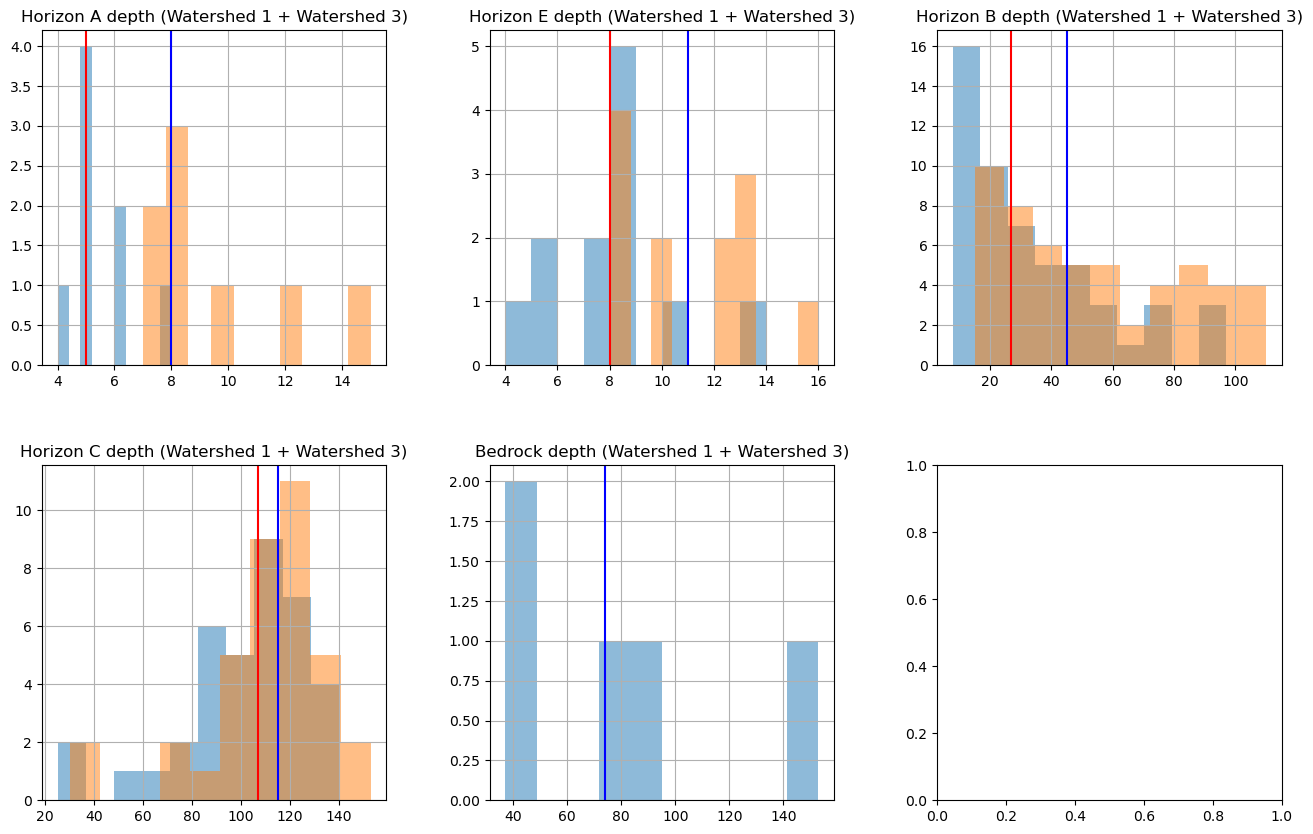

In [4]:
fig, axes = plt.subplots(2, 3, figsize = (16, 10))
for i, h in enumerate(['A','E','B','C']):
    ax = axes.flat[i]
    horizon_top.loc[h].hist(ax = ax, alpha = 0.5)
    ax.axvline(horizon_top.loc[h].median().iloc[0], color = 'r')
    horizon_depth.loc[h].hist(ax = ax, alpha = 0.5)
    ax.axvline(horizon_depth.loc[h].median().iloc[0], color = 'b')
    ax.set_title(f'Horizon {h} depth (Watershed 1 + Watershed 3)')
ax = axes.flat[4]
bedrock_depth.hist(ax = ax, alpha = 0.5)
ax.axvline(bedrock_depth.median(), color = 'b')
ax.set_title('Bedrock depth (Watershed 1 + Watershed 3)')

In [5]:
combined = pd.DataFrame(np.nan, index = ['Oie', 'Oa', 'A', 'E', 'B', 'C'], 
                        columns = ['CEC_ACID', 'CEC_Ca', 'CEC_Mg', 'CEC_Na', 'CEC_K', 'CEC_Al'])
combined.loc[['Oie', 'Oa'], :] = \
    cec_top.loc[['Oie', 'Oa'], 
                ['ExAcidcmolc_kg', 'ExCacmolc_kg', 'ExMgcmolc_kg', 'ExNacmolc_kg', 'ExKcmolc_kg', 'ExAlcmolc_kg']].values
combined.loc[['A', 'E', 'B', 'C'], 'CEC_ACID'] = cec_top.loc['Min', 'ExAcidcmolc_kg']
combined.loc[['A', 'E', 'B', 'C'], ['CEC_Ca', 'CEC_Mg', 'CEC_Na', 'CEC_K', 'CEC_Al']] = \
    cec_min.loc[['A', 'E', 'B', 'C'], 
                ['Ca_NH4Cl', 'Mg_NH4Cl', 'K_NH4Cl', 'Na_NH4Cl', 'Al_NH4Cl']].values
combined.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_CEC.csv'))
combined

,CEC_ACID,CEC_Ca,CEC_Mg,CEC_Na,CEC_K,CEC_Al
Oie,8.918391,9.819770,1.882701,0.113851,1.389885,2.582701
Oa,5.431279,4.407803,0.953468,0.142948,0.740578,7.667283
A,1.677191,2.769625,0.709500,0.572000,0.095375,5.394625
E,1.677191,0.349250,0.081833,0.106583,0.043667,2.542750
B,1.677191,0.246654,0.064712,0.104577,0.044596,6.572192
C,1.677191,0.055344,0.006125,0.030063,0.030781,1.221906


In [6]:
# Convert from soil horizon to ELM soil layers
# Assume Oi = Oe; merge Oa and A because they occupy same layers
# O horizion ~7cm, B/C interface 60cm 
# Johnson, C. E., Driscoll, C. T., Blum, J. D., Fahey, T. J., & Battles, J. J. (2014). Soil Chemical Dynamics after Calcium Silicate Addition to a Northern Hardwood Forest. Soil Science Society of America Journal, 78(4), 1458–1468. https://doi.org/10.2136/sssaj2014.03.0114
horizon_interfaces = np.array([0, 2.5, 7, 10, 20, 60, 100])
elm_interfaces = np.array([0, 1.75, 4.51, 9.06, 16.55, 28.91, 49.29, 82.89, 138.28])
horizon_nodes = np.diff(horizon_interfaces)
elm_nodes = np.array([0.71, 2.79, 6.23, 11.89, 21.22, 36.61, 61.98, 100.38])

result = vert_interp(elm_nodes, horizon_nodes, combined.values.T, False,
                     elm_interfaces, horizon_interfaces)
elm_cec = pd.DataFrame(result.T, index = range(1, 9), columns = combined.columns)
elm_cec

,CEC_ACID,CEC_Ca,CEC_Mg,CEC_Na,CEC_K,CEC_Al
1,8.918391,9.819770,1.882701,0.113851,1.389885,2.582701
2,6.378864,5.878447,1.205977,0.135041,0.917020,6.285603
3,3.731626,3.666123,0.843012,0.337200,0.448464,6.638343
4,1.677191,0.653009,0.160606,0.164993,0.050156,2.900662
5,1.677191,0.275291,0.069491,0.105137,0.044337,5.447469
6,1.677191,0.246654,0.064712,0.104577,0.044596,6.572192
7,1.677191,0.116324,0.024799,0.053814,0.035185,2.927310
8,1.677191,0.055344,0.006125,0.030063,0.030781,1.221906


## Soil solution pH and cation concentrations - initial state

### Use watershed 3 data to examine groundwater versus soil pore water chemistry

We decide not to use groundwater chemistry

Text(0.5, 1.0, '')

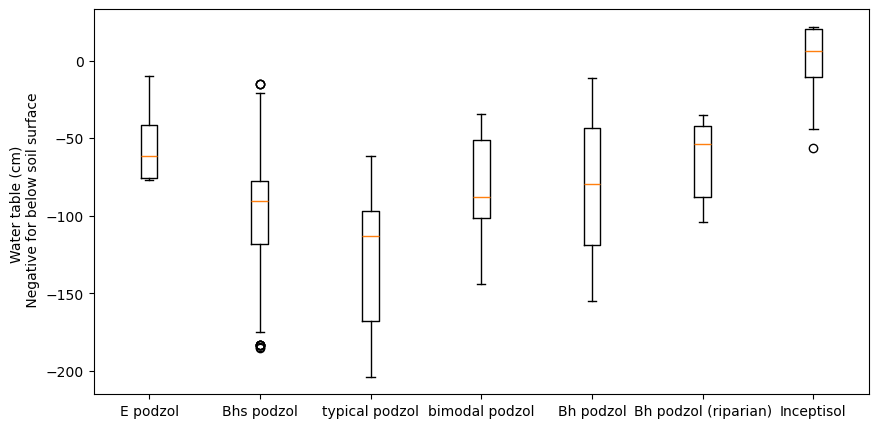

In [7]:
# Check groundwater table depth
data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                'Hubbard_Brook', 'knb-lter-hbr.317.3',
                                'W3-subsurface-water-chemistry.csv'), parse_dates=True)

data = data[['date','type','watertable']]
data.loc[data['watertable'] < -99.8, 'watertable'] = np.nan
data['date'] = pd.DatetimeIndex(data['date'])
data = data.dropna(subset = 'watertable')

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for i, type in enumerate(['G1','G2','G3','G4','G5','G6','G8']):
    temp = data.loc[data['type'] == type, :]
    ax.boxplot(-temp['watertable'], positions = [i])
    ax.set_title(type)
ax.set_xticklabels(['E podzol','Bhs podzol','typical podzol','bimodal podzol','Bh podzol',
                    'Bh podzol (riparian)','Inceptisol'])
ax.set_ylabel('Water table (cm) \n Negative for below soil surface')
ax.set_title('')

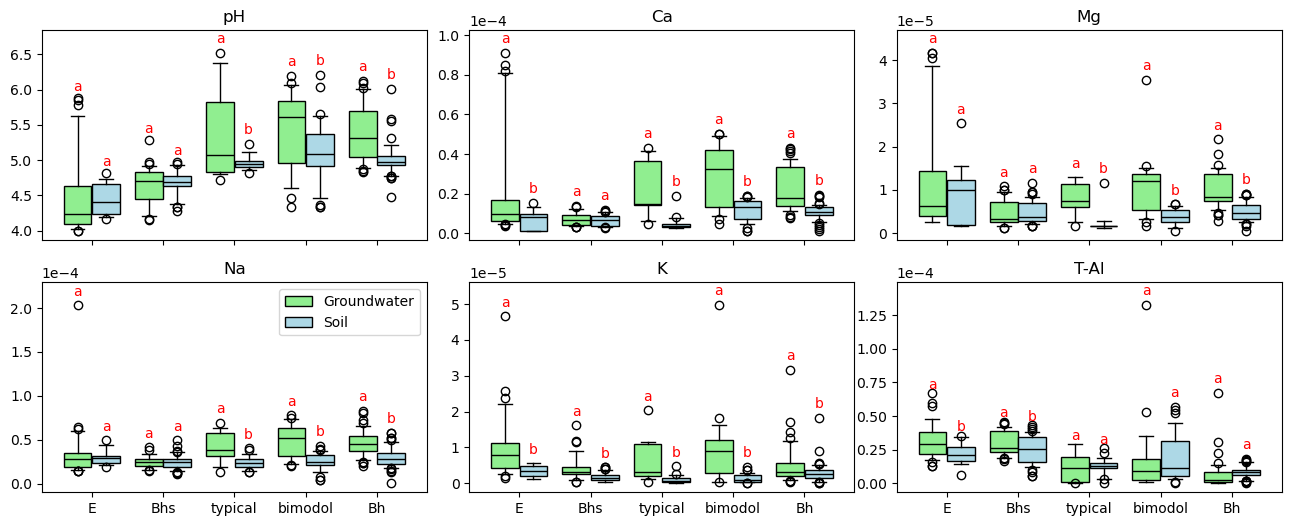

In [8]:
# Use statistical tests to compare between groundwater and soil pore water
data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                'Hubbard_Brook', 'knb-lter-hbr.317.3',
                                'W3-subsurface-water-chemistry.csv'), parse_dates=True)
# 'sample','site','wellID'
data = data[['date','pH','type','Ca','Mg','Na','K','T-Al']]
for i, cation in enumerate(['pH','Ca','Mg','Na','K','T-Al']):
    data.loc[data[cation] < 0, cation] = np.nan
data['date'] = pd.DatetimeIndex(data['date'])

""" # Preliminary graphical examination

# E podzol, Bhs podzol, typical podzol, bimodol podzol, Bh podzol, (G7) bedrock groundwater
name = ['E podzol','Bhs podzol','typical podzol','bimodol podzol','Bh podzol','bedrock']
mass = [1, 40, 24, 23, 39, 27]

for i, cation in enumerate(['pH','Ca','Mg','Na','K','T-Al']):
    if i == 0:
        scale = 1
    else:
        scale = 1e-3 # milligramsPerLiter => mol/L

    fig, axes = plt.subplots(1, 6, figsize = (20, 3), sharex = True, sharey = True)
    for j, (gw, soil) in enumerate(zip(['G1','G2','G3','G4','G5','G7'],
                                       ['S1','S2','S3','S4','S5',''])):
        ax = axes.flat[j]

        temp = data.loc[data['type'] == gw, ['date',cation]]
        ax.plot(temp['date'], temp[cation] / mass[i] * scale, 'o', 
                label = 'Groundwater', markersize = 3)

        if len(soil) > 0:
            temp = data.loc[data['type'] == soil, ['date',cation]]
            ax.plot(temp['date'], temp[cation] / mass[i] * scale, 'o', 
                    label = 'Soil water', markersize = 3)

        ax.set_title(f'{cation} {name[j]}')

        if (i != 0) & (j == 0):
            ax.set_ylabel('mol L-1')

        if (j == 0):
            ax.legend()"""

name = ['E','Bhs','typical','bimodol','Bh'] # ,'bedrock'
mass = [1, 40, 24, 23, 39, 27]

fig, axes = plt.subplots(2, 3, figsize = (16, 6), sharex = True, sharey = False)
fig.subplots_adjust(wspace = 0.11)
for i, cation in enumerate(['pH','Ca','Mg','Na','K','T-Al']):
    if i == 0:
        scale = 1
    else:
        scale = 1e-3 # milligramsPerLiter => mol/L

    ax = axes.flat[i]

    for j, (gw, soil) in enumerate(zip(['G1','G2','G3','G4','G5'],
                                       ['S1','S2','S3','S4','S5'])):

        temp_gw = data.loc[data['type'] == gw, ['date',cation]].set_index('date')
        temp_soil = data.loc[data['type'] == soil, ['date',cation]].set_index('date')

        # pick the values measured during the same period
        start = max(min(temp_gw.index), min(temp_soil.index))
        end = min(max(temp_gw.index), max(temp_soil.index))

        temp_gw = temp_gw.loc[(temp_gw.index >= start) & (temp_gw.index <= end)].dropna()
        temp_soil = temp_soil.loc[(temp_soil.index >= start) & (temp_soil.index <= end)].dropna()

        b1 = ax.boxplot(temp_gw / mass[i] * scale, positions = [j-0.2], widths = 0.39, 
                        patch_artist = True, whis = [5, 95])
        b1['boxes'][0].set_facecolor('lightgreen')
        b1['medians'][0].set_color('k')
        b2 = ax.boxplot(temp_soil / mass[i] * scale, positions = [j+0.2], widths = 0.39,
                        patch_artist = True, whis = [5, 95])
        b2['boxes'][0].set_facecolor('lightblue')
        b2['medians'][0].set_color('k')

        # Welch's t-test
        t_stat, p_value = stats.ttest_ind(temp_gw, temp_soil, equal_var=False)
        ylim = ax.get_ylim()
        ypos_1 = np.percentile(temp_gw / mass[i] * scale, 100) + (ylim[1] - ylim[0])*0.05
        ypos_2 = np.percentile(temp_soil / mass[i] * scale, 100) + (ylim[1] - ylim[0])*0.05
        if p_value < 0.05:
            lab_1 = 'a'
            lab_2 = 'b'
        else:
            lab_1 = 'a'
            lab_2 = 'a'
        ax.text(j-0.2, ypos_1, lab_1, horizontalalignment='center', color = 'r')
        ax.text(j+0.2, ypos_2, lab_2, horizontalalignment='center', color = 'r')

    ax.set_ylim(ylim[0], ylim[1] + (ylim[1] - ylim[0])*0.07)
    ax.set_xticks(range(5))
    ax.set_xticklabels(name)
    ax.set_title(cation)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    if (cation == 'Na'):
        ax.legend([b1['boxes'][0], b2['boxes'][0]], ['Groundwater', 'Soil'])

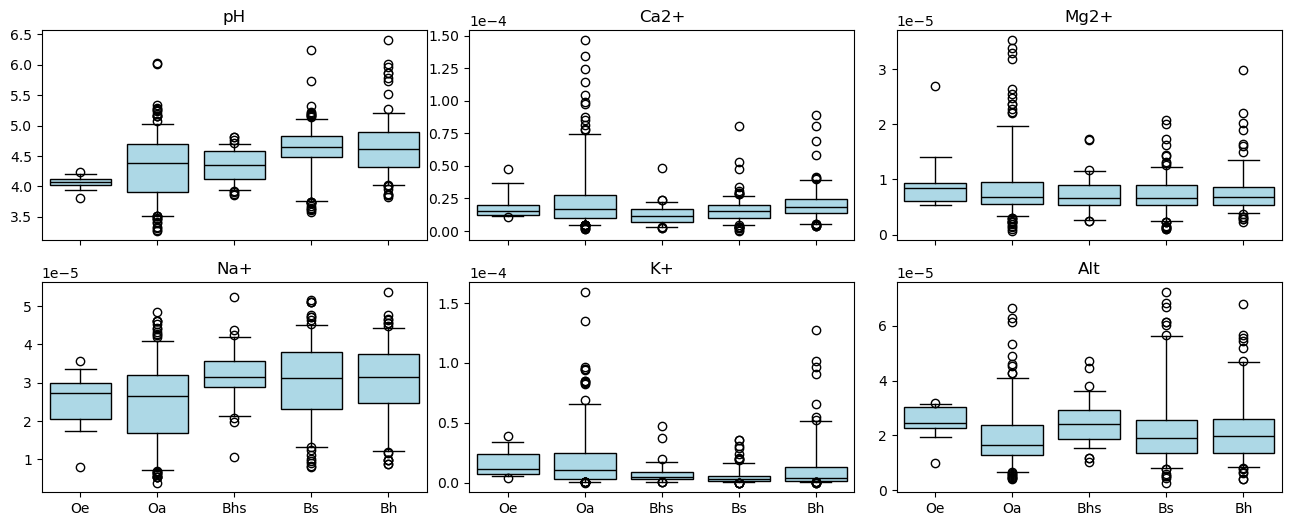

In [9]:
""" Examine the vertical distribution of watershed 1 pore water chemistry """ 
data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                'Hubbard_Brook', 'knb-lter-hbr.138.11',
                                'W1Lysim_HB1996-2020.csv'), parse_dates=True)
data = data.loc[pd.DatetimeIndex(data['Date']) < np.datetime64('1999-10-01'), :]
# homogenize the horizon notationss
data['Horizon'] = [r[:-1] if r.endswith('1') or r.endswith('2') or r.endswith('3') \
                   else r for r in data['Horizon']]
#data.loc[data['Horizon'] == 'Oa', 'Horizon'] = 'Oae'
#data.loc[data['Horizon'] == 'Oe', 'Horizon'] = 'Oae'
data = data[['Horizon', 'pH', 'Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt']].set_index('Horizon')
data[data < 0] = np.nan
# umol/L => mol/L
data.iloc[:, 1:] = data.iloc[:, 1:] * 1e-6


fig, axes = plt.subplots(2, 3, figsize = (16, 6), sharex = True, sharey = False)
fig.subplots_adjust(wspace = 0.11)
for i, cation in enumerate(['pH', 'Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt']):
    if i == 0:
        scale = 1
    else:
        scale = 1e-3 # milligramsPerLiter => mol/L

    ax = axes.flat[i]

    # This is in vertical depth order
    for j, horizon in enumerate(['Oe', 'Oa', 'Bhs', 'Bs', 'Bh']):

        temp = data.loc[horizon, cation].dropna()

        b1 = ax.boxplot(temp, positions = [j], widths = 0.8, 
                        patch_artist = True, whis = [5, 95])
        b1['boxes'][0].set_facecolor('lightblue')
        b1['medians'][0].set_color('k')

    ax.set_xticks(range(5))
    ax.set_xticklabels(['Oe', 'Oa', 'Bhs', 'Bs', 'Bh'])
    ax.set_title(cation)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [10]:
data = data.reset_index()
data['Horizon'] = data['Horizon'].replace(['Bhs', 'Bh', 'Bs'], 'B')
data = data.set_index('Horizon')
data_mean = data.groupby(['Horizon']).mean().loc[['Oe', 'Oa', 'B'], :]
data_mean.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_solution.csv'))
data_mean.index = ['Oie'] + list(data_mean.index[1:])

# interpolate
bmd = (20 + 60) / 2 # mean depth of B horizon
oamd = (2.5 + 7) / 2 # mean depth of Oa horizon
data_mean.loc['A', :] = data_mean.loc['Oa', :] * (bmd-8.5) / (bmd-oamd) + \
    data_mean.loc['B', :] * (8.5-oamd) / (bmd-oamd)
data_mean.loc['E', :] = data_mean.loc['Oa', :] * (bmd-15) / (bmd-oamd) + \
    data_mean.loc['B', :] * (15-oamd) / (bmd-oamd)
data_mean.loc['C', :] = data_mean.loc['B', :]

# re-order
data_mean = data_mean.loc[['Oie', 'Oa', 'A', 'E', 'B', 'C'], :]

data_mean

,pH,Ca2+,Mg2+,Na+,K+,Alt
Oie,4.061667,0.000020,0.000010,0.000025,0.000016,0.000024
Oa,4.311969,0.000024,0.000009,0.000025,0.000019,0.000020
A,4.340436,0.000023,0.000009,0.000025,0.000018,0.000020
E,4.389778,0.000022,0.000008,0.000026,0.000016,0.000021
B,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023
C,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023


In [11]:
# Convert from soil horizon to ELM soil layers
horizon_interfaces = np.array([0, 2.5, 7, 10, 20, 60, 100])
elm_interfaces = np.array([0, 1.75, 4.51, 9.06, 16.55, 28.91, 49.29, 82.89, 138.28])
horizon_nodes = np.diff(horizon_interfaces)
elm_nodes = np.array([0.71, 2.79, 6.23, 11.89, 21.22, 36.61, 61.98, 100.38])

result = vert_interp(elm_nodes, horizon_nodes, data_mean.values.T, False,
                     elm_interfaces, horizon_interfaces)
elm_sol = pd.DataFrame(result.T, index = range(1, 9), columns = data_mean.columns)
elm_sol

,pH,Ca2+,Mg2+,Na+,K+,Alt
1,4.061667,0.000020,0.000010,0.000025,0.000016,0.000024
2,4.243952,0.000023,0.000009,0.000025,0.000018,0.000021
3,4.324857,0.000024,0.000009,0.000025,0.000018,0.000020
4,4.383586,0.000022,0.000008,0.000026,0.000016,0.000020
5,4.526584,0.000018,0.000008,0.000029,0.000010,0.000022
6,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023
7,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023
8,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023


## Soil texture and organic matter content

ORGANIC:units = "kg/m3 (assumed carbon content 0.58 gC per gOM)"



Deeper data, knb-lter-hbr.210.2

    C_pct
    C percent
    organic carbon concentration, percent by weight
    float

<Axes: >

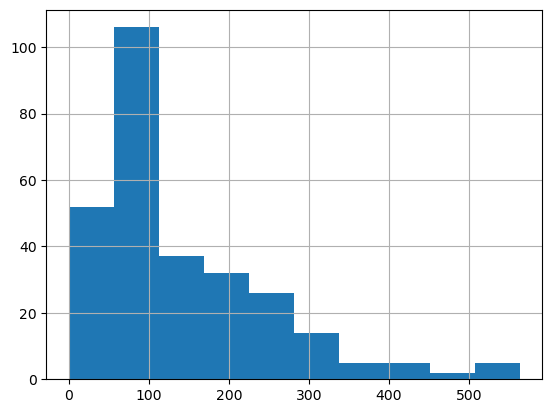

In [12]:
""" THIS IS NOT USED """
# (1) Check the soil organic matter content in kg/m3
# But not enough layer depth is available
path_chem = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                         'Hubbard_Brook', 'knb-lter-hbr.176.3')
layer_depth = pd.read_csv(os.path.join(path_chem, 'HubbardBrook_ForestFloor_SiteInfo_W1.csv'))
layer_chem = pd.read_csv(os.path.join(path_chem, 'HubbardBrook_ForestFloor_SoilChem_W1.csv'))

layer_depth = layer_depth.loc[layer_depth['Year'] <= 1998, :].set_index(['Year', 'Plot'])
layer_depth = layer_depth.loc[:, ['Oie_Thickness1','Oie_Thickness2','Oie_Thickness3',
                                  'Oie_Thickness4','Oie_Thickness5','Oie_Thickness6',
                                  'Oie_Thickness7','Oie_Thickness8']]
layer_depth[layer_depth <= -990] = np.nan
layer_depth = layer_depth.dropna(axis = 0, how = 'all')

layer_chem = layer_chem.loc[layer_chem['Year'] <= 1998, ['Year', 'Plot', 'Horizon', 'OM_OM']]
layer_chem = layer_chem.set_index(['Year','Plot'])

layer_combined = pd.concat([layer_chem, layer_depth], axis = 1
                           ).dropna(axis = 0, subset = list(layer_depth.columns), how = 'all')
layer_combined['Oie_Thickness'] = layer_combined.loc[:, layer_depth.columns].mean(axis = 1)

(layer_combined['OM_OM'] / (layer_combined['Oie_Thickness']*0.01)).hist()

In [13]:
""" THIS IS USED INSTEAD OF THE ABOVE """
# (2) Use the known organic_max from ELM parameter file to convert % organic matter weight
#     to kg/m3
organic_max = 130
# (2.1) surface
path_chem = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                         'Hubbard_Brook', 'knb-lter-hbr.176.3')
layer_chem = pd.read_csv(os.path.join(path_chem, 'HubbardBrook_ForestFloor_SoilChem_W1.csv'))
layer_chem = layer_chem.loc[layer_chem['Year'] <= 1998, ['Year', 'Plot', 'Horizon', 'PercentC']]
layer_chem = layer_chem.set_index(['Year','Plot'])
layer_chem.loc[layer_chem['PercentC'] < -800, 'PercentC'] = np.nan
layer_chem['pct_OM'] = layer_chem['PercentC']/100 * 1.72 * organic_max
layer_chem = layer_chem.groupby('Horizon').mean()

# (2.2) deeper - no data from watershed 1 or 6; use watershed 3 data
folder = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'Hubbard_Brook',
                        'knb-lter-hbr.210.2')
pedon = pd.read_csv(os.path.join(folder, 'pedon.csv'))
pedon = pedon.loc[((pd.DatetimeIndex(pedon['date']).year <= 1998) & \
                   (pedon['project'] == 'WS1lys')) | pedon['pedon'].str.startswith('WS3') |
                  pedon['pedon'].isin(['HB013', 'HB026', 'HB175']), 'pedon']
data = pd.read_csv(os.path.join(folder, 'horizon.csv'))
data = data.loc[data['pedon'].isin(pedon), ['pedon', 'horizon', 'top_cm', 'base_cm', 'C_pct']]
data['horizon'] = [
    r[:-1] if r.endswith('1') or r.endswith('2') or r.endswith('3') or r.endswith('4') or r.endswith('5') or r.endswith('6') else r for r in data['horizon']]
data['horizon'] = [
    r[1:] if r.startswith('2') or r.startswith('3') else r for r in data['horizon']]

# standardize the horizon names 
data['horizon'] = data['horizon'].replace(['Oe','Oi'], 'Oie')
data['horizon'] = [c[:2] if c.startswith('Oa') else c for c in data['horizon']]
data['horizon'] = [c[:1] if not (c == 'Oie' or c == 'Oa') else c for c in data['horizon']]

# Calculate the average
data = data.drop(['top_cm', 'base_cm'], axis = 1).set_index(['pedon', 'horizon'])

data_mean = data.groupby(['horizon']).mean().loc[('Oie','Oa','A','E','B','C'), :]
data_mean['pct_OM'] = data_mean['C_pct']/100 * 1.72 * organic_max

# (2.3) combine 2.1 and 2.2: prefer 2.1 for Oie and Oia
combined_chem = pd.Series(np.nan, index = ['Oie', 'Oa', 'A', 'E', 'B', 'C'])
combined_chem.loc[['Oie', 'Oa']] = layer_chem.loc[['Oie','Oa'], 'pct_OM'].values
combined_chem.loc[['A', 'E', 'B','C']] = data_mean.loc[['A', 'E', 'B','C'], 'pct_OM'].values
combined_chem

Oie    99.389565
Oa     55.047017
A      29.366133
E       3.402609
B       9.899382
C       1.256715
dtype: float64

In [14]:
# Convert from soil horizon to ELM soil layers
horizon_interfaces = np.array([0, 2.5, 7, 10, 20, 60, 100])
elm_interfaces = np.array([0, 1.75, 4.51, 9.06, 16.55, 28.91, 49.29, 82.89, 138.28])
horizon_nodes = np.diff(horizon_interfaces)
elm_nodes = np.array([0.71, 2.79, 6.23, 11.89, 21.22, 36.61, 61.98, 100.38])

result = vert_interp(elm_nodes, horizon_nodes, combined_chem.to_frame().values.T, False,
                     elm_interfaces, horizon_interfaces)
elm_om = pd.DataFrame(result.T, index = range(1, 9), columns = ['OM'])
elm_om

,OM
1,99.389565
2,67.096622
3,43.420067
4,6.661048
5,8.085962
6,9.899382
7,4.011565
8,1.256715


In [15]:
# Put all the ELM inputs together 
elm_input = pd.concat([elm_cec, elm_sol, elm_om], axis = 1)
elm_input['CEC_TOT'] = elm_input[['CEC_ACID', 'CEC_Ca', 'CEC_Mg', 'CEC_Na', 'CEC_K', 
                                  'CEC_Al']].sum(axis = 1).values
elm_input.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_elm_input.csv'))
elm_input

,CEC_ACID,CEC_Ca,CEC_Mg,CEC_Na,CEC_K,CEC_Al,pH,Ca2+,Mg2+,Na+,K+,Alt,OM,CEC_TOT
1,8.918391,9.819770,1.882701,0.113851,1.389885,2.582701,4.061667,0.000020,0.000010,0.000025,0.000016,0.000024,99.389565,24.707299
2,6.378864,5.878447,1.205977,0.135041,0.917020,6.285603,4.243952,0.000023,0.000009,0.000025,0.000018,0.000021,67.096622,20.800952
3,3.731626,3.666123,0.843012,0.337200,0.448464,6.638343,4.324857,0.000024,0.000009,0.000025,0.000018,0.000020,43.420067,15.664769
4,1.677191,0.653009,0.160606,0.164993,0.050156,2.900662,4.383586,0.000022,0.000008,0.000026,0.000016,0.000020,6.661048,5.606617
5,1.677191,0.275291,0.069491,0.105137,0.044337,5.447469,4.526584,0.000018,0.000008,0.000029,0.000010,0.000022,8.085962,7.618916
6,1.677191,0.246654,0.064712,0.104577,0.044596,6.572192,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023,9.899382,8.709922
7,1.677191,0.116324,0.024799,0.053814,0.035185,2.927310,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023,4.011565,4.834623
8,1.677191,0.055344,0.006125,0.030063,0.030781,1.221906,4.579556,0.000017,0.000007,0.000031,0.000008,0.000023,1.256715,3.021410


In [16]:
co2_atm = 360.7 * 1e-5

elm_input['Ca2+']*2 + elm_input['Mg2+']*2 + elm_input['Na+'] + elm_input['K+'] + elm_input['Alt']*3 + 10**(-elm_input['pH']) # - 10**(-14+elm_input['pH']) - 4.38e-8*co2_atm/10**(-elm_input['pH']) - 2*7.20443620415286e-19*co2_atm/10**(-2*elm_input['pH'])

1    0.000260
2    0.000226
3    0.000214
4    0.000206
5    0.000188
6    0.000182
7    0.000182
8    0.000182
dtype: float64

In [17]:
# Calculate the exchange coefficient
K_AH = pd.DataFrame(np.nan, index = elm_input.index,
                    columns = ['Ca', 'Mg', 'Na', 'K', 'Al'])

alpha_theta = 3.4
for ion,ion2,valint in zip(['Ca', 'Mg', 'Na', 'K', 'Al'], 
                           ['Ca2+', 'Mg2+', 'Na+' , 'K+', 'Alt'],
                           [2,2,1,1,3]):
    beta_h = (elm_input['CEC_ACID']/elm_input['CEC_TOT']).values
    h = 10**(-elm_input['pH'].values)
    cation = elm_input[ion2].values
    beta_cation = (elm_input[f'CEC_{ion}'] / elm_input['CEC_TOT']).values

    K_AH.loc[:, ion] = h * beta_cation**(1/valint) / cation**(1/valint) / beta_h

    ## Kanzaki equation
    # K_AH.loc[:, ion] = 10**(alpha_theta*(1-beta_h)) * \
    #    h * beta_cation**(1/valint) / cation**(1/valint) / beta_h
    # print(beta_cation, beta_h)
LOG_K_AH = np.log10(K_AH)
LOG_K_AH.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_logkm.csv'))
LOG_K_AH.T

,1,2,3,4,5,6,7,8
Ca,-1.466422,-1.684074,-1.704042,-1.998676,-2.222559,-2.253371,-2.544406,-2.807782
Mg,-1.672753,-1.824669,-1.803073,-2.090741,-2.331303,-2.363721,-2.699817,-3.105562
Na,-1.357957,-1.313087,-0.765917,-0.809907,-1.198263,-1.270595,-1.559136,-1.812006
K,-0.082371,-0.346240,-0.508941,-1.111537,-1.112802,-1.060682,-1.163624,-1.221693
Al,-2.408211,-2.343670,-2.257763,-2.391615,-2.366306,-2.357471,-2.644986,-2.907565


In [18]:
beta_h = 0.36096179
h = 10**(-4.331449)
beta_cation = 0.3974441
cation = 0.000025
valint = 2
10**(3.4*(1-beta_h)) * h * beta_cation**(1/valint) / cation**(1/valint) / beta_h

2.4237493476736502

## Check surface CEC and solution over time

In [19]:
data = pd.read_excel(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                  'Hubbard_Brook', 'knb-lter-hbr.158.1',
                                  'w1ffexchem.xlsx'),
                     index_col = [3, 1, 2])

# 'Min', 'cor', 'min' probably all means mineral soil of top 10cm
new_index_level_0 = [t if t in ['Oa', 'Oie'] else 'Min' for t in data.index.get_level_values(0)]
data.index = pd.MultiIndex.from_arrays([new_index_level_0, data.index.get_level_values(1),
                                        data.index.get_level_values(2)], 
                                        names = ['Horizon','Year','Plot'])

data = data[['ExAcidcmolc_kg','ExCacmolc_kg', 'ExMgcmolc_kg', 
             'ExNacmolc_kg', 'ExKcmolc_kg', 'ExAlcmolc_kg']].sort_index()
data[data < 0] = np.nan

data

ExAcidcmolc_kg  ExCacmolc_kg  ExMgcmolc_kg  ExNacmolc_kg  \
Horizon Year Plot                                                              
Min     1998 3.0              7.45          0.11          0.13          0.10   
             4.0             15.48          0.46          0.34          0.23   
             7.0             14.08          0.24          0.46          0.16   
             10.0             6.38          0.18          0.17          0.07   
             12.0            12.94          0.88          0.42          0.18   
...                            ...           ...           ...           ...   
Oie     2010 192.0            5.42         39.84          3.93          0.03   
             194.0            8.49         27.30          4.66          0.11   
             196.0            4.55         19.52          3.09          0.03   
             197.0            3.84          4.12          1.01          0.25   
             199.0            5.49          6.02          1.42          0.06   

                    ExKcmolc_kg  ExAlcmolc_kg  
Horizon Year Plot                              
Min     1998 3.0           0.17          3.53  
             4.0           0.49         16.05  
             7.0           0.53          8.74  
             10.0          0.24          4.54  
             12.0          0.45          9.59  
...                         ...           ...  
Oie     2010 192.0         1.70           NaN  
             194.0         2.61           NaN  
             196.0         1.54           NaN  
             197.0         0.56           NaN  
             199.0         0.94           NaN  

[1661 rows x 6 columns]

<Figure size 800x600 with 0 Axes>

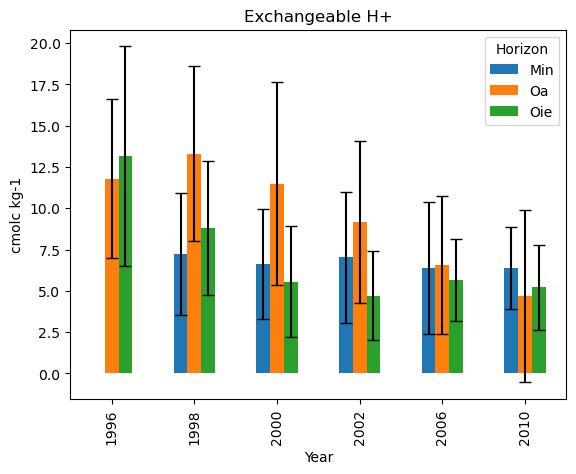

<Figure size 800x600 with 0 Axes>

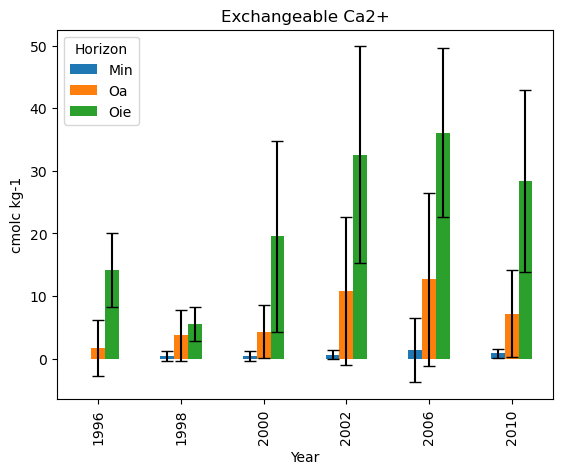

<Figure size 800x600 with 0 Axes>

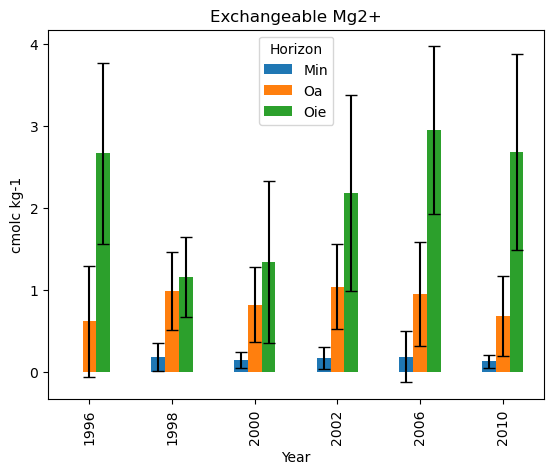

<Figure size 800x600 with 0 Axes>

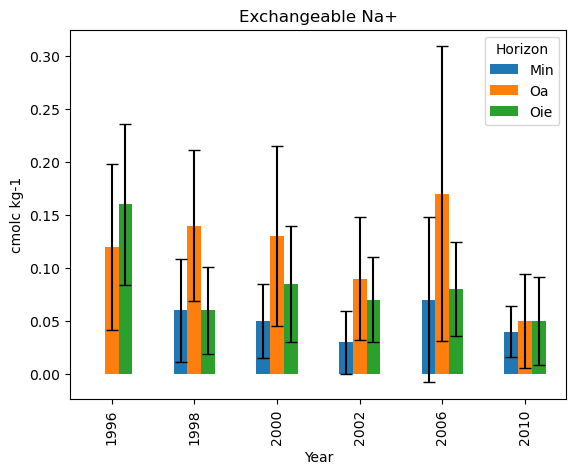

<Figure size 800x600 with 0 Axes>

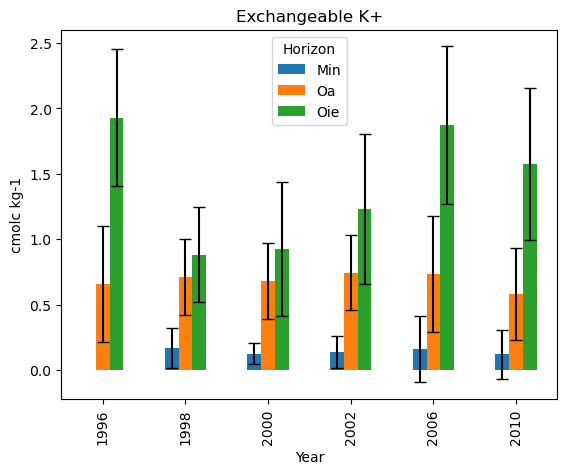

<Figure size 800x600 with 0 Axes>

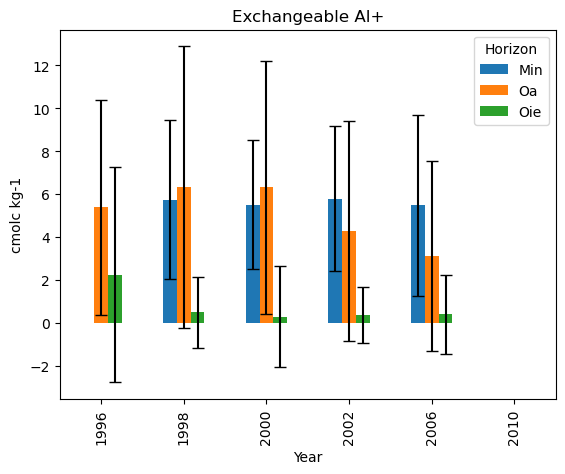

In [20]:
for cation in data.columns:
    data_mean = data[cation].groupby(['Year', 'Horizon']).median().unstack()
    data_std = data[cation].groupby(['Year', 'Horizon']).std().unstack()

    plt.figure(figsize = (8,6))
    data_mean.plot(kind='bar', yerr=data_std, capsize=4)

    cation = cation.replace('cmolc_kg','').replace('Ex','')
    if cation == 'Acid':
        cation = 'H+'
    elif cation in ['Ca','Mg']:
        cation = cation + '2+'
    else:
        cation = cation + '+'
    plt.title(f'Exchangeable {cation}')
    plt.ylabel('cmolc kg-1')
    plt.savefig(f'./temp/hbr_soil_{cation}.png', dpi = 600, bbox_inches = 'tight')

/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',


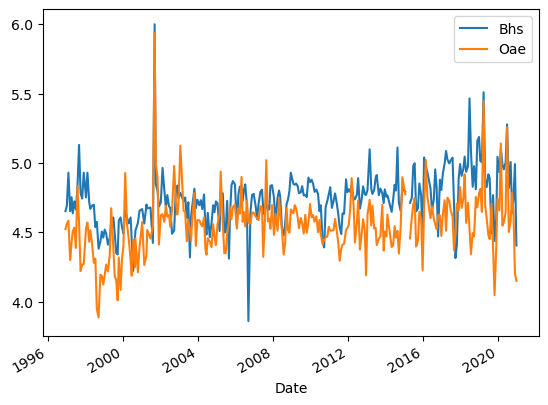

In [26]:
data = read_lysimeter()
for horizon in data[0].index.levels[0]:
    data[0].loc[horizon, 'pH'].plot(label = horizon)
plt.legend()